# Quantum Phase Estimation

We will now demonstrate an example for Phase Estimation using Hadamard Test using Qiskit for a phase gate as shown below.

## Real Hadamard Test Circuit

In [27]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import QFT
import numpy as np

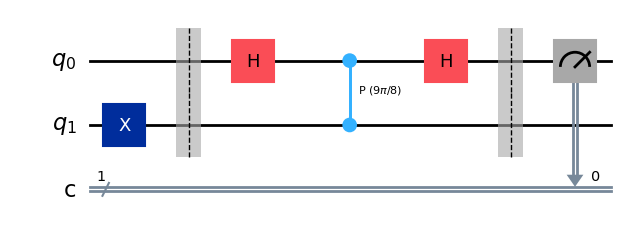

In [2]:
qc_re = QuantumCircuit(2,1)

qc_re.x(1)
qc_re.barrier()
qc_re.h(0)
qc_re.cp(2*np.pi*0.5625,0,1)
qc_re.h(0)
qc_re.barrier()
qc_re.measure(0,0)
qc_re.draw('mpl')

In [3]:
shots_re=100000
result_re = (AerSimulator()).run(transpile(qc_re, AerSimulator()),shots=shots_re).result()

In [4]:
counts_re = result_re.get_counts()

# Check if counts is not empty and key '0' exists
if counts_re:
    first_key_re = list(counts_re.keys())[0]
    print(counts_re[first_key_re])
else:
    print("No counts available.")

96181


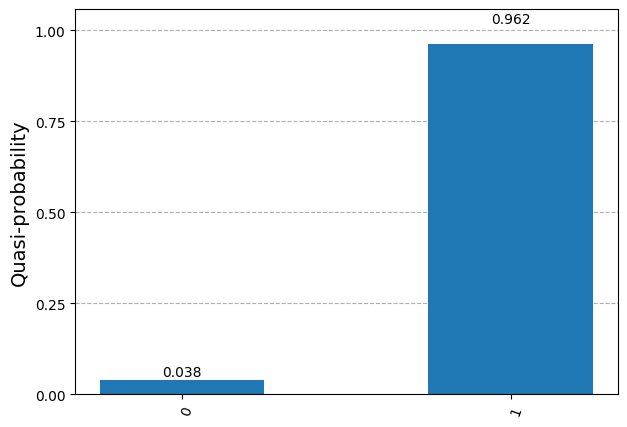

In [5]:
plot_distribution(counts_re)

In [6]:
counts_re.get('1',1)

96181

In [7]:
((1-2*(counts_re.get('1', 1)/shots_re)))

-0.9236200000000001

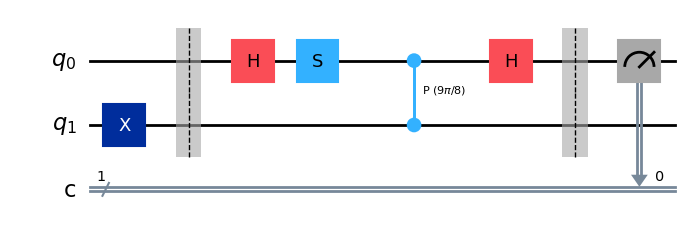

In [8]:
qc_im = QuantumCircuit(2,1)

qc_im.x(1)
qc_im.barrier()
qc_im.h(0)
qc_im.s(0)
qc_im.cp(2*np.pi*0.5625,0,1)
qc_im.h(0)
qc_im.barrier()

qc_im.measure(0,0)
qc_im.draw('mpl')

In [9]:
shots_im=10
result_im = (AerSimulator()).run(transpile(qc_im, AerSimulator()),shots=shots_im).result()
counts_im = result_im.get_counts()

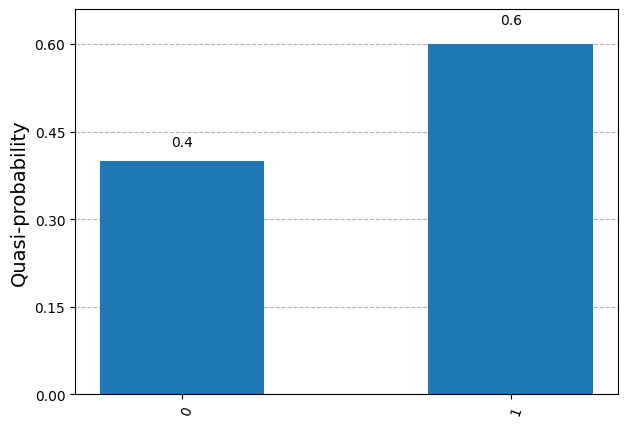

In [10]:
plot_distribution(counts_im)

In [11]:
counts_im.get('1',1)/shots_im

0.6

In [12]:
1-2*(counts_re.get('1', 1)/shots_re)

-0.9236200000000001

In [13]:
if counts_im.get('1',1)/shots_im < 0.5:
    print('theta = ',1-(np.arccos(1-2*(counts_re.get('1', 1)/shots_re)))/(2*np.pi) )
else:
    print('theta = ', (np.arccos(1-2*(counts_re.get('1', 1)/shots_re)))/(2*np.pi) )


theta =  0.4373921507388174


## Quantum Phase Estimation using Quantum Fourier Transform

In [428]:
#Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

# To run on hardware, selectthe backedn with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

In [486]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import QFT
import numpy as np

In [487]:
pm = generate_preset_pass_manager(backend=AerSimulator(), # backend=backend
                                  optimization_level=3)

In [783]:
b=3
t=3
phi =3**(-t) * b
# phi=0.125
print("phi = ", phi)
m=3
shots = 8192

phi =  0.1111111111111111


For example, taking the unitary matrix to be the phase gate as 

$T=\begin{pmatrix} 1 & 0 \\ 0 & e^{-2\pi\iota \phi} \end{pmatrix}$

and finding the phase corresponding to the $\ket{1}$ eigenvector

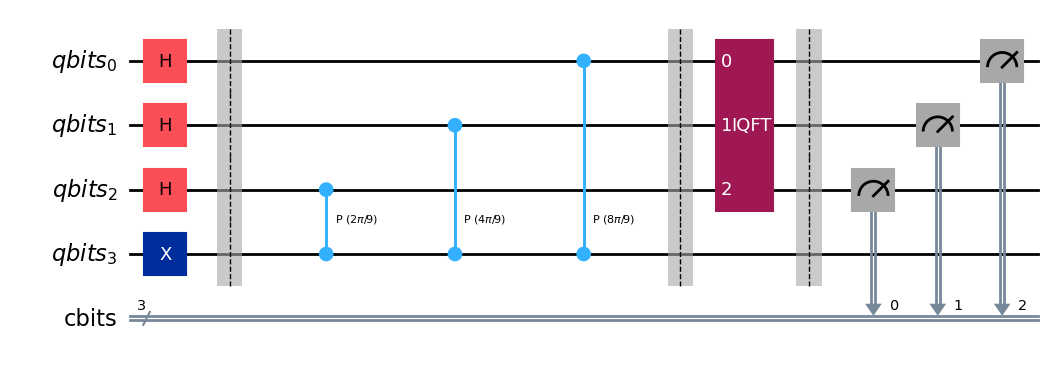

In [784]:
qbits = QuantumRegister(m+1,name='qbits')
cbits = ClassicalRegister(m,name='cbits')
qc = QuantumCircuit(qbits, cbits)
qc.h(qbits[:m])
qc.x(m)
qc.barrier()
for i in range(m):
    qc.cp(2*np.pi*phi*2**i, qbits[m-1-i], qbits[m])
qc.barrier()
qc.append(QFT(m, insert_barriers=True, do_swaps=True, inverse=True), qbits[:m])
qc.barrier()
for i in range(m):
    qc.measure(m-i-1, i)

qc.draw('mpl')

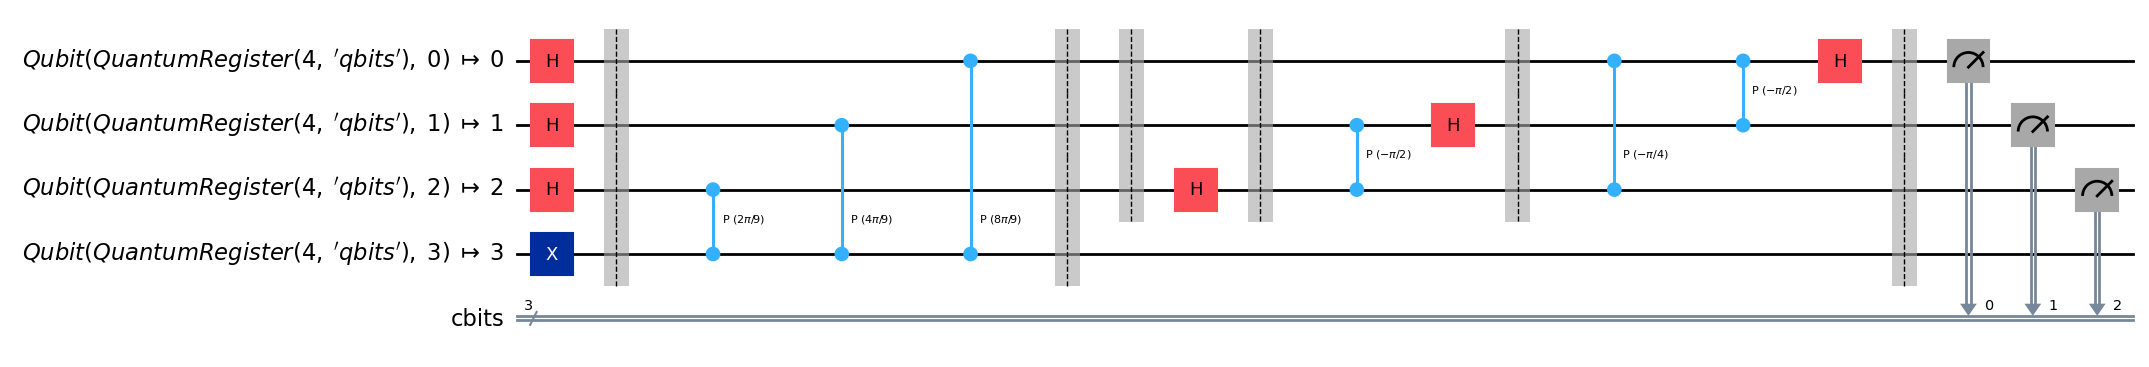

In [785]:
circuit_isa=pm.run(qc)
circuit_isa.draw(output="mpl",idle_wires=False,style="iqp")

In [786]:
sampler=Sampler(mode=AerSimulator()) #backend
sampler.options.default_shots=shots
result = sampler.run([circuit_isa]).result()
print("Result: ", result)
counts = result[0].data.cbits.get_counts()

Result:  PrimitiveResult([SamplerPubResult(data=DataBin(cbits=BitArray(<shape=(), num_shots=8192, num_bits=3>)), metadata={'shots': 8192, 'circuit_metadata': {}})], metadata={'version': 2})


In [787]:
counts

{'101': 718,
 '001': 4125,
 '100': 263,
 '010': 1964,
 '011': 993,
 '000': 120,
 '110': 7,
 '111': 2}

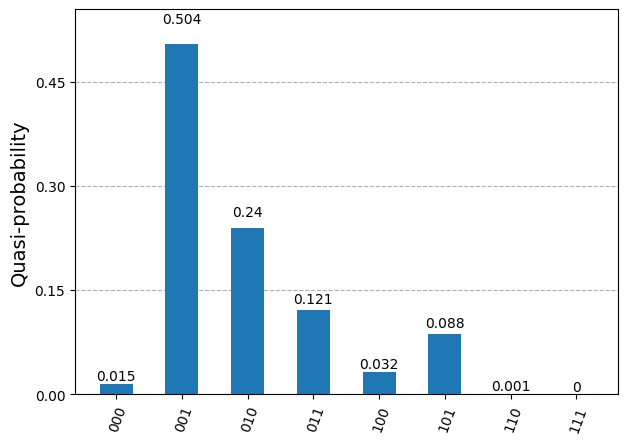

In [788]:
plot_distribution(counts)

In [789]:
max_key = max(counts, key=counts.get)
print(f"Key with the maximum count: {max_key}, Count: {counts[max_key]}")

Key with the maximum count: 001, Count: 4125


In [790]:
# Convert binary to decimal
max_key_decimal = int(max_key, 2)
print(f"Key with the maximum count in decimal: {max_key_decimal}")
print(f"Number of divisons: {2**m}")
print(f"Phase estimation: {max_key_decimal/2**m}")

Key with the maximum count in decimal: 1
Number of divisons: 8
Phase estimation: 0.125
